#0.Connexion à Google Drive

In [ ]:
#Initialisation du google drive
from google.colab import drive
drive.mount('/gdrive')

#Lien: https://drive.google.com/drive/folders/1vkE4PW2dqjFF7_bn3R2VIvI6covY3xkh?usp=sharing

Mounted at /gdrive


# 1.Telechargement et décompression du dataset sélectionné

In [ ]:
#install Kaggle
!pip install -q kaggle

from google.colab import files
files.upload()

#create kaggle folder
!mkdir ~/.kaggle

#copy kaggle.jason ~/.kaggle
! cp kaggle.json ~/.kaggle

#permission for json to act
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download abdallahalidev/plantvillage-dataset
!unzip plantvillage-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.G

#2.Import des packages

In [ ]:
#Librairies communes
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Autres librairies communes utiles au projet
import time, cv2
import os
import glob, cv2
import random
import tensorflow as tf

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#tensorflox
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


#keras
from keras.preprocessing import image


def matrice_confusion(x, y, xlabel, ylabel, figsize=(10,8), normalize='true', vmin=0, vmax=1, fmt='.0%', cmap=None):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(x, y, normalize=normalize)

    label = pd.concat([x, y],axis=0).sort_values().unique()

    df_cm = pd.DataFrame(cm, index=label, columns=label)

    df_cm.index.name = xlabel
    df_cm.columns.name = ylabel

    plt.figure(figsize=figsize)  
    ax = sns.heatmap(df_cm, annot=True, vmin=vmin, vmax=vmax, fmt=fmt, cmap=cmap)


#3.Preprocessing



### Initialisation des chemins et des classes

In [ ]:
#Initialisation des chemins pour aller chercher les images dans le google drive
#chemin_image = '/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/color'
chemin_image = 'plantvillage dataset/color'
chemin_image_segmented = 'plantvillage dataset/segmented'
chemin_image_fond = '/gdrive/MyDrive/epyphyte/donnees/photos_reelles/Fonds'
chemin_image_test = '/gdrive/MyDrive/epyphyte/donnees/test'  # 53 photos réelles
chemin_image_test2 = '/gdrive/MyDrive/epyphyte/donnees/test2' # 53 photos color
chemin_image_test3 = '/gdrive/MyDrive/epyphyte/donnees/test3' # 53 photos segmented
checkpoint_filepath = '/gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2'
checkpoint_unet = '/gdrive/MyDrive/epyphyte/entrainement/checkpoints/UNET'
path_segmented='/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/segmented'
path_color='/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/color'
path_fond='/gdrive/MyDrive/epyphyte/donnees/photos_reelles/Fonds/Fond_01.jpg'

#Paramètres de modélisation               
largeur = 224
hauteur = 224
profondeur = 3
EPOCHS = 30
batch_size = 32

#Dictionnaires liens numéros <> classes
df = pd.read_csv('/gdrive/MyDrive/epyphyte/donnees/info_maladie.csv', sep=';')
#df = pd.read_csv('/gdrive/M/epyphyte/donnees/info_maladie.csv', sep=';')


def dataframe_to_dictionnary(dataframe, cle, valeur):
  # Renvoie un dictionnaire à partir de 2 colonnes d'un dataframe
  df_temp = dataframe[[cle, valeur]].set_index(cle)
  return df_temp[valeur].to_dict()

CLASSES = dataframe_to_dictionnary(df, 'dossier', 'classe')
reversed_classes = dataframe_to_dictionnary(df, 'classe', 'dossier')

nb_classes = len(CLASSES)
print("Le nombre de classes est: ",nb_classes)

Le nombre de classes est:  38


In [ ]:
#Construction du DataFrame avec le chemin des images et les catégories
df_chemin = pd.DataFrame()
for (repertoire, sousRepertoires, fichiers) in os.walk(path_segmented):
    df_temp = pd.DataFrame(data=fichiers, columns=['fichier'])
    df_temp['dossier'] = repertoire
    df_chemin = pd.concat([df_chemin, df_temp], axis = 0)

df_chemin['chemin_segmented'] = df_chemin['dossier'] +'/'+ df_chemin['fichier']

df_chemin['dossier']=df_chemin['dossier'].apply(lambda x: x[64:])
df_chemin['plante_maladie']=df_chemin['dossier'].apply(lambda x: x.split('/')[0])
df_chemin['plante']=df_chemin['plante_maladie'].apply(lambda x: x.split('___')[0])
df_chemin['maladie']=df_chemin['plante_maladie'].apply(lambda x: x.split('___')[1])

df_chemin = df_chemin.drop('dossier', axis=1)
df_chemin = df_chemin.drop('fichier', axis=1)

df_chemin['chemin_color']=df_chemin['chemin_segmented'].apply(lambda x: x.replace("segmented","color",1))
df_chemin['chemin_color']=df_chemin['chemin_color'].apply(lambda x: x.replace("_final_masked","",1))
df_chemin['chemin_color']=df_chemin['chemin_color'].apply(lambda x: x.replace("jpg","JPG",1))

df_chemin['chemin_mask']=df_chemin['chemin_segmented'].replace(to_replace='/color/',value='/mask/',regex=True)

df_chemin.head()

chemin_segmented  ...                                        chemin_mask
0  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...  ...  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...
1  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...  ...  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...
2  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...  ...  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...
3  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...  ...  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...
4  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...  ...  /gdrive/MyDrive/epyphyte/donnees/plantvillage_...

[5 rows x 6 columns]

### Gestion des fonds

In [ ]:
liste_img_fond = []

#Recherche et chagement de la liste des images de fonds
for fichier in glob.glob(chemin_image_fond + '/**/*.*', recursive=True):
  img_fond = cv2.imread(fichier)
  img_fond = cv2.cvtColor(img_fond, cv2.COLOR_BGR2RGB)
  img_fond = cv2.resize(img_fond, (largeur,hauteur))
  liste_img_fond.append(img_fond)

#Définition de la fonction de preprocessing pour remplacer les fonds noir par l'image de fond
def preprocess_input2(img):
  img = np.where(img <= 10, random.choice(liste_img_fond), img)
  return preprocess_input(img)

def get_mask(img):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = (img_gray> 10)*255
  img = img.astype(np.uint8)
  return img

###Visualisation des données

chemin color =  /gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/color/Apple___Cedar_apple_rust/402aad30-3914-4227-a9b4-4d40a49fae72___FREC_C.Rust 0230.JPG
chemin segmented =  /gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/segmented/Apple___Cedar_apple_rust/402aad30-3914-4227-a9b4-4d40a49fae72___FREC_C.Rust 0230_final_masked.jpg


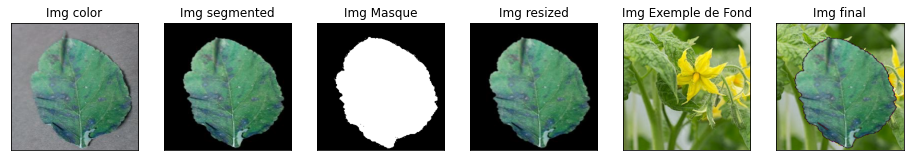

In [ ]:
#Visualisation de la segmentation
fig = plt.figure(figsize = (16,12))

rdm=random.randint(0,len(df))

#Affichage d'une image aléatoire
print("chemin color = ",df_chemin.iloc[rdm]['chemin_color'])
print("chemin segmented = ",df_chemin.iloc[rdm]['chemin_segmented'])
img_color = cv2.imread(df_chemin.iloc[rdm]['chemin_color'],cv2.IMREAD_COLOR)
img_segmented = cv2.imread(df_chemin.iloc[rdm]['chemin_segmented'], cv2.IMREAD_COLOR)
img_mod = cv2.resize(img_segmented, (largeur,hauteur))
img_fond = cv2.imread(path_fond,cv2.IMREAD_COLOR)
img_fond = cv2.cvtColor(img_fond, cv2.COLOR_BGR2RGB)
img_fond = cv2.resize(img_fond, (largeur,hauteur))
img_mod = cv2.resize(img_segmented, (largeur,hauteur))

fig.add_subplot(1,5,1)
plt.imshow(img_color)
plt.xticks([])
plt.yticks([])
plt.title('Img color')

fig.add_subplot(1,5,2)
plt.imshow(img_segmented)#cmap='gray'
plt.xticks([])
plt.yticks([])
plt.title('Img segmented')

img_mask=get_mask(img_segmented)

fig.add_subplot(1,5,3)
plt.imshow(img_mask,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Img Masque')

fig.add_subplot(1,5,4)
plt.imshow(img_fond)
plt.xticks([])
plt.yticks([])
plt.title('Img Exemple de Fond')

#Utilisation de tf.where pour remplacer le fond noir de l'image segmenté
tf_mod = tf.Variable(img_mod)
tf_fond = tf.Variable(img_fond)
tf_final = tf.where(tf_mod<10,tf_fond,tf_mod) 
#tf_final= preprocess_input2(img_mod)

fig.add_subplot(1,5,5)
plt.imshow(tf_final)
plt.xticks([])
plt.yticks([])
plt.title('Img final')

plt.show()

Sur l'image finale, on peut constater un liseré autour de la feuille.

Ce liseré pourrait biaiser notre modèle.

#4.Méthode 2: Utilisation du modèle VGG16 sur les données segmentées avec images de fonds

##Preprocessing

In [ ]:
#Chargement des données d'entrées par l'utilisation d'ImageDataGenerator pour éviter les problèmes de mémoire
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input2,
                                          #rotation_range = 10,
                                          #width_shift_range = 0.1,
                                          #height_shift_range = 0.1,
                                          #zoom_range = 1.1,
                                          horizontal_flip = True,
                                          vertical_flip = True,
                                          #rescale=1/255.,  # probablement déjà dans preprocess_input
                                          validation_split=0.2,
                                          )

valid_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input2,
                                          #rescale=1/255.,  # probablement déjà dans preprocess_input
                                          validation_split=0.2)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = train_data_generator.flow_from_directory(directory = chemin_image_segmented,
                                                           classes = CLASSES,
                                                           subset = 'training',
                                                           seed = 7,
                                                           class_mode = 'sparse',
                                                           target_size = (largeur, hauteur), 
                                                           batch_size = batch_size)

valid_generator = valid_data_generator.flow_from_directory(directory = chemin_image_segmented,
                                                           classes = CLASSES,
                                                           subset = 'validation',
                                                           seed = 7,
                                                           class_mode = 'sparse',
                                                           target_size = (largeur, hauteur), 
                                                           batch_size = batch_size)

Found 43457 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


##Création du modèle

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])


## Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

earling_stopping = EarlyStopping(monitor='val_loss',
                                 min_delta = 0.01, 
                                 patience = 5, 
                                 mode='min',
                                 restore_best_weights=True,
                                 verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         patience=3,
                                         min_delta=0.01,
                                         factor=0.5, 
                                         cooldown = 4, 
                                         verbose = 1)

checkpoint = ModelCheckpoint(checkpoint_filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max')

## Entraînement

In [ ]:
history = model.fit_generator(generator=train_generator, 
                              epochs = EPOCHS,
                              steps_per_epoch = 1310//batch_size,
                              validation_data = valid_generator,
                              validation_steps = 334//batch_size,
                              callbacks = [earling_stopping, 
                                           reduce_learning_rate,
                                           checkpoint
                                          ],
                              verbose = True,
                              )

model.save('/gdrive/MyDrive/epyphyte/entrainement/modeles/VGG16_avec_transfer_learning_v2/')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 3.2276 - acc: 0.3195
Epoch 00001: saving model to /gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2
INFO:tensorflow:Assets written to: /gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2/assets
40/40 [==============================] - 39s 453ms/step - loss: 3.2276 - acc: 0.3195 - val_loss: 1.8792 - val_acc: 0.4750 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 1.9434 - acc: 0.4891
Epoch 00002: saving model to /gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2
INFO:tensorflow:Assets written to: /gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2/assets
40/40 [==============================] - 26s 657ms/step - loss: 1.9434 - acc: 0.4891 - val_loss: 1.4593 - val_acc: 0.5750 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 1.5884 - acc: 

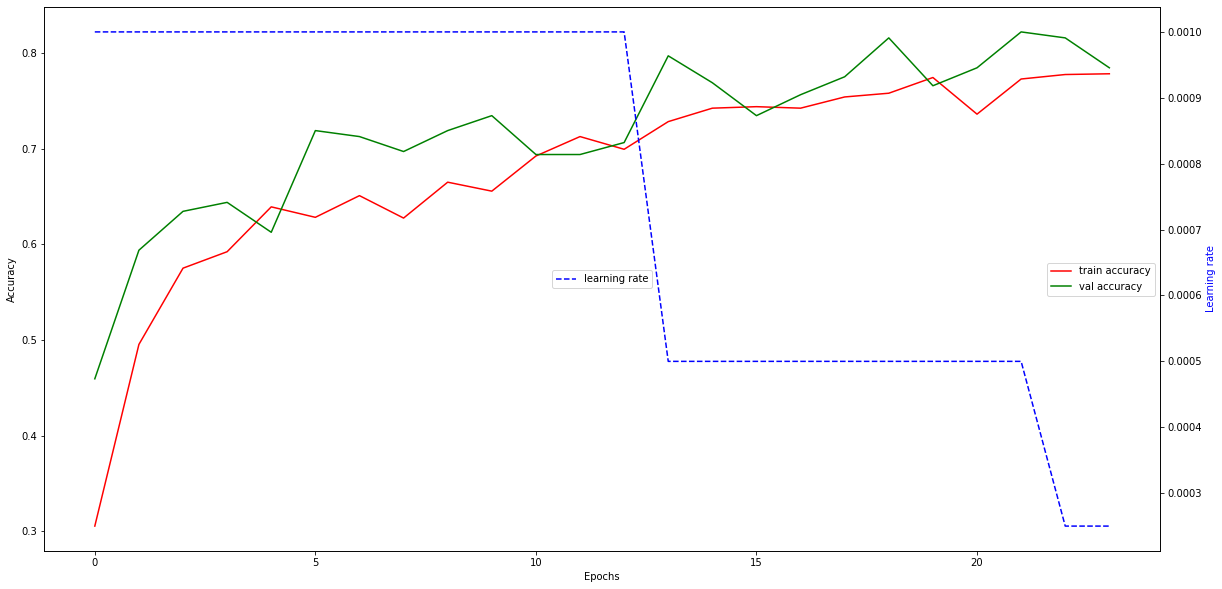

In [ ]:
#Affichage des données d'entrainement du modèle VGG16
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(history.history['acc'], label='train accuracy', color='red')
ax1.plot(history.history['val_acc'], label='val accuracy', color='green')
ax2.plot(history.history['lr'], '--', label='learning rate', color='blue')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='k')
ax2.set_ylabel('Learning rate', color='b')

ax1.legend(loc='center right')
ax2.legend(loc='center')
plt.show()


## Evaluation

###Chargement du modèle

In [ ]:
model = load_model('/gdrive/MyDrive/epyphyte/entrainement/modeles/VGG16_avec_transfer_learning_v2/')

### Prédictions

In [ ]:
#Initialisation des listes vides
liste_num_classe_reelle = []
liste_num_classe_pred = []
liste_photo = []

#Chargement des images de test et la classe associée
i = 0
for fichier in glob.glob(chemin_image_test + '/**/*.jpg', recursive=True,):
    i += 1

    img = image.load_img(fichier, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    num_classe_pred = model.predict(x).argmax(axis = 1)[0]
    liste_num_classe_pred.append(num_classe_pred)

    chemin = os.path.split(fichier)[0]
    nom_classe_reelle = os.path.split(chemin)[1]
    num_classe_reelle = CLASSES[nom_classe_reelle]
    liste_num_classe_reelle.append(num_classe_reelle)

    liste_photo.append(img)


# Chargement d'informations complémentaires sur les classes
result = pd.DataFrame()
result['reel'] = liste_num_classe_reelle
result['pred'] = liste_num_classe_pred
result['image'] = liste_photo

result = pd.merge(result, df, left_on=['reel'], right_on=['classe'])[['reel','pred','image','dossier','plante_francais']]
result = result.rename({'dossier' : 'nom_classe_reelle',
                        'plante_francais' : 'plante_reelle'}, axis = 1)

result = pd.merge(result, df, left_on=['pred'], right_on=['classe'])[['reel','pred','image','nom_classe_reelle', 'plante_reelle','dossier','plante_francais']]
result = result.rename({'dossier' : 'nom_classe_pred',
                        'plante_francais' : 'plante_pred'}, axis = 1)

result


###Evaluation par classe

In [ ]:
pd.crosstab(result['reel'], result['pred'], rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True)

Classe prédite  0  1  3  4  6  11  12  16  25  26  28  29  30  31  32  37  All
Classe réelle                                                                 
0               1  2  3  0  0   0   0   0   0   0   1   0   0   0   0   0    7
11              0  1  0  0  0   3   1   0   0   1   0   0   0   0   1   0    7
21              0  0  0  1  0   0   0   0   0   0   0   1   2   0   0   0    4
25              1  0  1  0  0   1   0   2   3   1   0   0   0   0   0   0    9
28              0  0  0  0  0   0   0   2   0   1   0   0   0   0   3   0    6
29              0  0  1  0  1   0   0   4   0   0   1   0   4   1   1   1   14
31              0  0  0  0  0   0   0   0   1   0   1   0   0   2   0   2    6
All             2  3  5  1  1   4   1   8   4   3   3   1   6   3   5   3   53

In [ ]:
print(classification_report(result['nom_classe_reelle'], result['nom_classe_pred']))

                                   precision    recall  f1-score   support

               Apple___Apple_scab       0.50      0.14      0.22         7
                Apple___Black_rot       0.00      0.00      0.00         0
                  Apple___healthy       0.00      0.00      0.00         0
              Blueberry___healthy       0.00      0.00      0.00         0
Cherry_(including_sour)___healthy       0.00      0.00      0.00         0
                Grape___Black_rot       0.75      0.43      0.55         7
     Grape___Esca_(Black_Measles)       0.00      0.00      0.00         0
           Peach___Bacterial_spot       0.00      0.00      0.00         0
             Potato___Late_blight       0.00      0.00      0.00         4
          Squash___Powdery_mildew       0.75      0.33      0.46         9
         Strawberry___Leaf_scorch       0.00      0.00      0.00         0
          Tomato___Bacterial_spot       0.00      0.00      0.00         6
            Tomato___Ear

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

###Evaluation par plante

In [ ]:
pd.crosstab(result['plante_reelle'], result['plante_pred'], rownames=['Plante réelle'], colnames=['Plante prédite'], margins=True)

Plante prédite  Cerise  Courge  Fraise  Myrtille  ...  Pêche  Tomate  Vigne  All
Plante réelle                                     ...                           
Courge               0       3       1         0  ...      2       0      1    9
Pomme                0       0       0         0  ...      0       1      0    7
Pomme de terre       0       0       0         1  ...      0       3      0    4
Tomate               1       1       1         0  ...      6      16      0   26
Vigne                0       0       1         0  ...      0       1      4    7
All                  1       4       3         1  ...      8      21      5   53

[6 rows x 9 columns]

In [ ]:
print(classification_report(result['plante_reelle'], result['plante_pred']))

                precision    recall  f1-score   support

        Cerise       0.00      0.00      0.00         0
        Courge       0.75      0.33      0.46         9
        Fraise       0.00      0.00      0.00         0
      Myrtille       0.00      0.00      0.00         0
         Pomme       0.60      0.86      0.71         7
Pomme de terre       0.00      0.00      0.00         4
         Pêche       0.00      0.00      0.00         0
        Tomate       0.76      0.62      0.68        26
         Vigne       0.80      0.57      0.67         7

      accuracy                           0.55        53
     macro avg       0.32      0.26      0.28        53
  weighted avg       0.69      0.55      0.59        53



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

###Affichage des photos bien classées

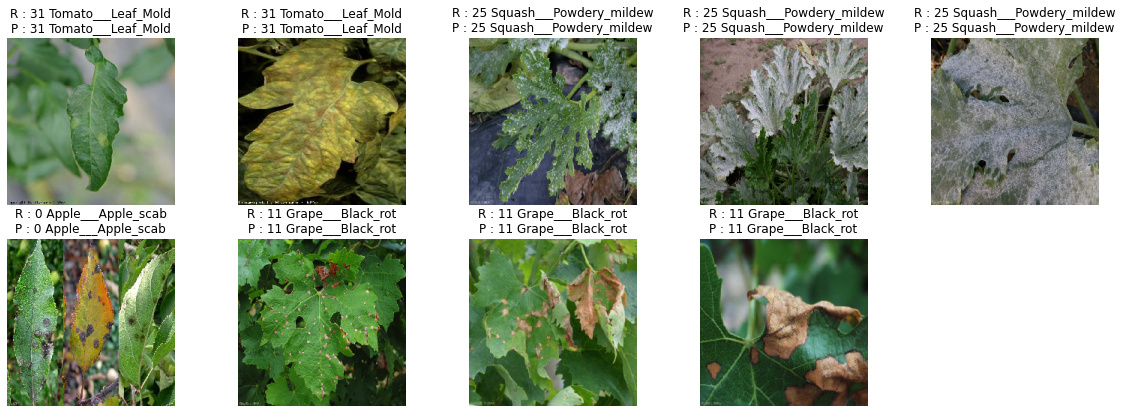

In [ ]:
plt.figure( figsize= (20,40) ) 
k = 0
for i in range(len(result)):
    num_classe_reelle = result.loc[i, 'reel']
    num_classe_pred = result.loc[i, 'pred']

    if num_classe_reelle == num_classe_pred:
        nom_classe_reelle = result.loc[i, 'nom_classe_reelle']
        nom_classe_pred = result.loc[i, 'nom_classe_pred']
        img = result.loc[i, 'image']

        k += 1
        plt.subplot(11,5,k)
        plt.imshow(img)
        plt.axis('off')
        plt.title('R : ' + str(num_classe_reelle) + ' ' + nom_classe_reelle + '\n' + 'P : ' + str(num_classe_pred) + ' ' + nom_classe_pred)

####Affichage des photos mal classées

In [ ]:
plt.figure( figsize= (20,40) ) 
k = 0
for i in range(len(result)):
    num_classe_reelle = result.loc[i, 'reel']
    num_classe_pred = result.loc[i, 'pred']

    if num_classe_reelle != num_classe_pred:
        nom_classe_reelle = result.loc[i, 'nom_classe_reelle']
        nom_classe_pred = result.loc[i, 'nom_classe_pred']
        img = result.loc[i, 'image']

        k += 1
        plt.subplot(11,5,k)
        plt.imshow(img)
        plt.axis('off')
        plt.title('R : ' + str(num_classe_reelle) + ' ' + nom_classe_reelle + '\n' + 'P : ' + str(num_classe_pred) + ' ' + nom_classe_pred)



Output hidden; open in https://colab.research.google.com to view.

Pour le mildiou de la tomate, on peut remarquer qu'à 4 reprises, le modèle ne se trompe que sur l'état avancé ou non de la maladie. 
Il faudrait peut-être envisager la fusion des classes :
- Tomato___Early_blight et Tomato___Late_blight
- Potato___Early_blight et Potato___Late_blight

#5.Méthode 3: Utilisation d'un modèle Unet non préentrainé pour la segmentation

##Preprocessing

In [ ]:
#Basé sur le lien: https://github.com/keras-team/keras/blob/v2.7.0/keras/preprocessing/image.py#L994-L1137

# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     #preprocessing_function=preprocess_unet,
                     rescale=1/255.
                     )

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
#---
#Ajout d'un tableau de quelques images pour la normalisation des datagen
X_light=[]
y_light=[]

for chemins_img in df_chemin['chemin_color'].head(10):
  img_courante=cv2.imread(chemins_img,cv2.IMREAD_COLOR)
  X_light.append(img_courante)

for chemins_img in df_chemin['chemin_mask'].head(10):
  mask_courant=cv2.imread(chemins_img,cv2.IMREAD_COLOR)#cv2.IMREAD_GRAYSCALE
  y_light.append(mask_courant)

seed = 1
image_datagen.fit(X_light, augment=True, seed=seed)
mask_datagen.fit(y_light, augment=True, seed=seed)
#---

image_generator = image_datagen.flow_from_dataframe(dataframe=df_chemin,
                                                    x_col="chemin_color",
                                                    batch_size=batch_size,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode=None,
                                                    target_size=(256,256))

mask_generator = image_datagen.flow_from_dataframe(dataframe=df_chemin,
                                                    x_col="chemin_mask",
                                                    batch_size=batch_size,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode=None,
                                                    target_size=(256,256))


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2725 invalid image filename(s) in x_col="chemin_color". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 51607 validated image filenames.
Found 54332 validated image filenames.


Il y a des problème de fichiers non détectés à cause des extention .JPG et .jpg

##Construction du modèle UNET

In [ ]:
def unet(pretrained_weights = None, input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=2)(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2))(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2))(conv3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2))(conv4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    up6 = concatenate([UpSampling2D(size=(2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    up7 = concatenate([UpSampling2D(size=(2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    up8 = concatenate([UpSampling2D(size=(2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    up9 = concatenate([UpSampling2D(size=(2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1,1, activation='sigmoid')(conv9)

    model_unet = Model(inputs=inputs, outputs=conv10)

    return model_unet

In [ ]:
model_unet = unet()
model_unet.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
callbacks_unet = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(checkpoint_unet, verbose=1, save_best_only=True, save_weights_only=True)
    ]

In [ ]:
STEP_SIZE_TRAIN=(df_chemin.shape[0]*.8)//batch_size
STEP_SIZE_TRAIN=(df_chemin.shape[0]*.2)//batch_size

train_generator = zip(image_generator, mask_generator)

history_unet = model_unet.fit(train_generator, 
                              epochs = EPOCHS,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              callbacks = callbacks_unet,
                              verbose = True,
                              )

model_unet.save('/gdrive/MyDrive/epyphyte/entrainement/modeles/UNET/')

Epoch 1/30
  7/339 [..............................] - ETA: 6:44:44 - loss: -5994225.5000 - accuracy: 6.8120e-08

KeyboardInterrupt: ignored

Arrêt de l'entrainement à cause de la durée de calcul.

##Evaluation

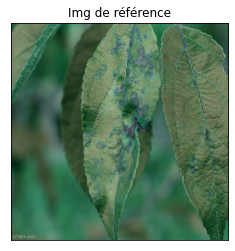

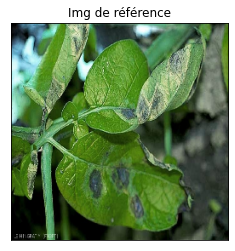

In [ ]:
img_path="/gdrive/MyDrive/epyphyte/donnees/test/Apple___Apple_scab/Pommier-tavelure-Caffier-IN.jpg"
img_path2="/gdrive/MyDrive/epyphyte/donnees/test/Potato___Late_blight/Mildiou1.jpg"

img = cv2.imread(img_path,cv2.IMREAD_COLOR)
img2= cv2.imread(img_path2,cv2.IMREAD_COLOR)

img_resized= cv2.resize(img, (256,256))
img_resized2= cv2.resize(img2, (256,256))

plt.imshow(img_resized)
plt.xticks([])
plt.yticks([])
plt.title('Img de référence');
plt.show()

plt.imshow(img_resized2)
plt.xticks([])
plt.yticks([])
plt.title('Img de référence');

plt.show()

In [ ]:
img_test=img_resized/255

mask_pred = model_unet.predict(img_test,batch_size=1)

plt.imshow(mask_pred)
plt.xticks([])
plt.yticks([])
plt.title('Masque Predit');


ValueError: ignored

##Conclusion

Il y a encore beaucoup d'amélioration à réaliser pour la mise en place de ce modèle:
 - Réduire le temps d'entrainement ( utiliser des données sur la machine virutelle et non sur le google drive ou réduite la quantité de données)
 
- Apprendre à utiliser la méthode .predict

#6.Méthode 4 : utilisation d'un modèle préentraîné de suppression de fond

Cette méthode consiste à supprimer le fond d'une photo à prédire, puis à donner cette photo au modèle entraîné à l'itération 2 sur les photos segmented.

Deux modèles préentraînés de suppression de fond ont été testés :
- MODNet (https://colab.research.google.com/drive/1Pt3KDSc2q7WxFvekCnCLD8P0gBEbxm6J?usp=sharing#scrollTo=prBcl0v0KvR2)
- U2net (https://github.com/OPHoperHPO/image-background-remove-tool)

Avant d'exécuter cette partie, il faut avoir exécuté :
- Connexion à Google Drive
- Import des packages
- Initialisation des chemins et des classes

##Chargement du modèle VGG16 entraîné sur les photos segmented

In [ ]:
model = load_model('/gdrive/MyDrive/epyphyte/entrainement/modeles/VGG16_segmented/')

##Evaluation avec MODNet

###Chargement du modèle MODNet

In [ ]:
# Clone the repository, and download the pre-trained model

import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for video matting
pretrained_ckpt = 'pretrained/modnet_webcam_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1Nf1ZxeJZJL8Qx9KadcYYyEmmlKhTADxX \
          -O pretrained/modnet_webcam_portrait_matting.ckpt

/content
Cloning into 'MODNet'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 249 (delta 21), reused 24 (delta 9), pack-reused 206
Receiving objects: 100% (249/249), 60.76 MiB | 28.58 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/MODNet
Downloading...
From: https://drive.google.com/uc?id=1Nf1ZxeJZJL8Qx9KadcYYyEmmlKhTADxX
To: /content/MODNet/pretrained/modnet_webcam_portrait_matting.ckpt
100% 26.3M/26.3M [00:00<00:00, 160MB/s]


In [ ]:
import PIL
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from src.models.modnet import MODNet


modnet = MODNet(backbone_pretrained=False)
modnet = nn.DataParallel(modnet).cuda()
modnet.load_state_dict(torch.load(pretrained_ckpt))
modnet.eval()


torch_transforms = transforms.Compose(
  [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ]
)


def modnet_matting(modnet, im_frame):
  im_PIL = PIL.Image.open(im_frame)
  im_PIL = im_PIL.resize((640,480), PIL.Image.ANTIALIAS)
  im_np = np.asarray(im_PIL)

  im_tensor = torch_transforms(im_PIL)
  im_tensor = im_tensor[None, :, :, :].cuda()
  
  _, _, matte_tensor = modnet(im_tensor, True)
  matte_tensor = matte_tensor.repeat(1, 3, 1, 1)
  matte_np = matte_tensor[0].data.cpu().numpy().transpose(1, 2, 0)
  fg_np = matte_np * im_np + (1 - matte_np) * np.full(im_np.shape, 255.0)

  fg_np = np.float32(fg_np)

  return fg_np

###Prédictions

Le modèle de suppression de fond MODNet remplace le fond par un fond blanc.
Or les photos segmented utilisées pour entraîner le modèle VGG16 sont sur fond noir. Avant de soumettre les photos à la prédiction, il faut donc remplacer le fond blanc par un fond noir.


In [ ]:
liste_num_classe_reelle = []
liste_num_classe_pred = []
liste_photo = []

i = 0
for fichier in glob.glob(chemin_image_test + '/**/*.jpg', recursive=True,):
    i += 1

    x = modnet_matting(modnet, fichier) # chargement de l'image et suppression du fond
    
    x = np.where(x >= 245, 0, x) # remplacement du fond blanc par un fond noir

    x = cv2.resize(x, dsize=(largeur,hauteur), interpolation = cv2.INTER_AREA)

    img = np.uint8(x)

    x = np.expand_dims(x, axis=0) # shape = (1, 224, 224, 3)
    x = preprocess_input(x)
    num_classe_pred = model.predict(x).argmax(axis = 1)[0]
    liste_num_classe_pred.append(num_classe_pred)

    chemin = os.path.split(fichier)[0]
    nom_classe_reelle = os.path.split(chemin)[1]
    num_classe_reelle = CLASSES[nom_classe_reelle]
    liste_num_classe_reelle.append(num_classe_reelle)

    liste_photo.append(img)


# Chargement d'informations complémentaires sur les classes
result = pd.DataFrame()
result['reel'] = liste_num_classe_reelle
result['pred'] = liste_num_classe_pred
result['image'] = liste_photo

result = pd.merge(result, df, left_on=['reel'], right_on=['classe'])[['reel','pred','image','dossier','plante_francais']]
result = result.rename({'dossier' : 'nom_classe_reelle',
                        'plante_francais' : 'plante_reelle'}, axis = 1)

result = pd.merge(result, df, left_on=['pred'], right_on=['classe'])[['reel','pred','image','nom_classe_reelle', 'plante_reelle','dossier','plante_francais']]
result = result.rename({'dossier' : 'nom_classe_pred',
                        'plante_francais' : 'plante_pred'}, axis = 1)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


###Evaluation par classe

Avec une accuracy de 0.06, le modèle se comporte moins bien qu'à l'itération 2 (modèle entraîné avec des fonds ajoutés : accuracy de 0.17

In [ ]:
print(classification_report(result['nom_classe_reelle'], result['nom_classe_pred']))

                                        precision    recall  f1-score   support

                    Apple___Apple_scab       0.00      0.00      0.00         7
                     Apple___Black_rot       0.00      0.00      0.00         0
                       Apple___healthy       0.00      0.00      0.00         0
                     Grape___Black_rot       0.00      0.00      0.00         7
          Grape___Esca_(Black_Measles)       0.00      0.00      0.00         0
                Peach___Bacterial_spot       0.00      0.00      0.00         0
         Pepper,_bell___Bacterial_spot       0.00      0.00      0.00         0
                  Potato___Late_blight       0.00      0.00      0.00         4
               Squash___Powdery_mildew       0.50      0.11      0.18         9
              Strawberry___Leaf_scorch       0.00      0.00      0.00         0
               Tomato___Bacterial_spot       0.00      0.00      0.00         6
                 Tomato___Early_blight 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

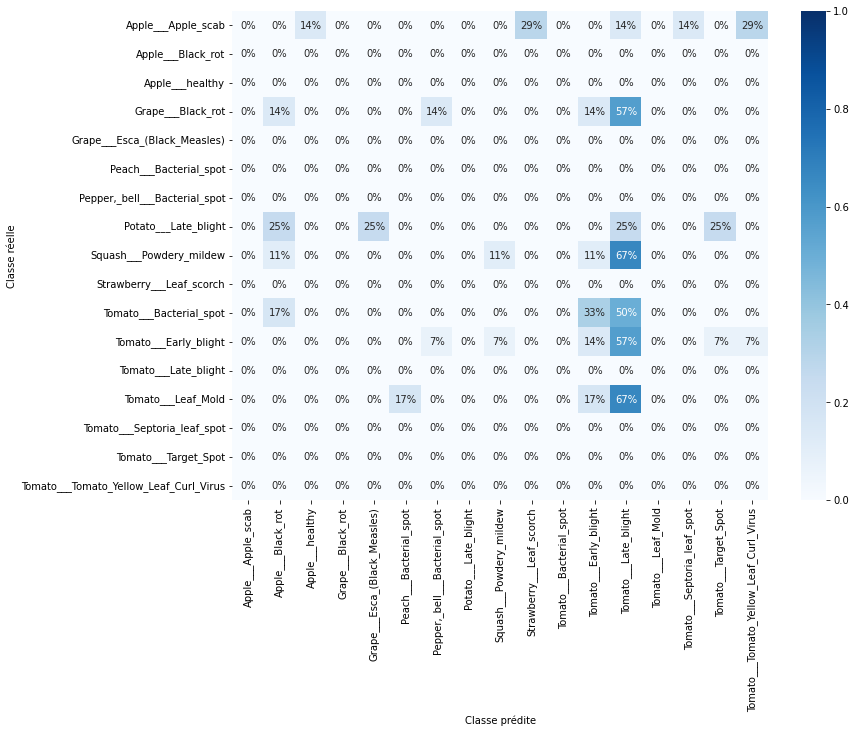

In [ ]:
matrice_confusion(result['nom_classe_reelle'], result['nom_classe_pred'], 'Classe réelle', 'Classe prédite', cmap = 'Blues', figsize=(12,9))

###Evaluation par plante

En faisant une jointure entre la classe (couple plante/maladie) et la plante, on peut obtenir les résultats par plante même si notre modèle ne renvoie qu'une seule sortie.

Le modèle prédit souvent une classe correspondant à la tomate.
Ceci est dû au déséquilibre du jeu de données.

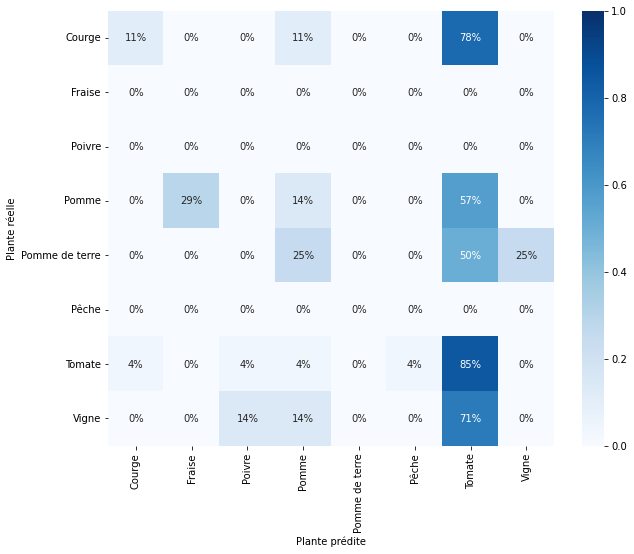

In [ ]:
matrice_confusion(result['plante_reelle'],result['plante_pred'], 'Plante réelle', 'Plante prédite', cmap='Blues')

In [ ]:
print(classification_report(result['plante_reelle'], result['plante_pred']))

                precision    recall  f1-score   support

        Courge       0.50      0.11      0.18         9
        Fraise       0.00      0.00      0.00         0
        Poivre       0.00      0.00      0.00         0
         Pomme       0.20      0.14      0.17         7
Pomme de terre       0.00      0.00      0.00         4
         Pêche       0.00      0.00      0.00         0
        Tomate       0.55      0.85      0.67        26
         Vigne       0.00      0.00      0.00         7

      accuracy                           0.45        53
     macro avg       0.16      0.14      0.13        53
  weighted avg       0.38      0.45      0.38        53



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

###Affichage des photos bien classées

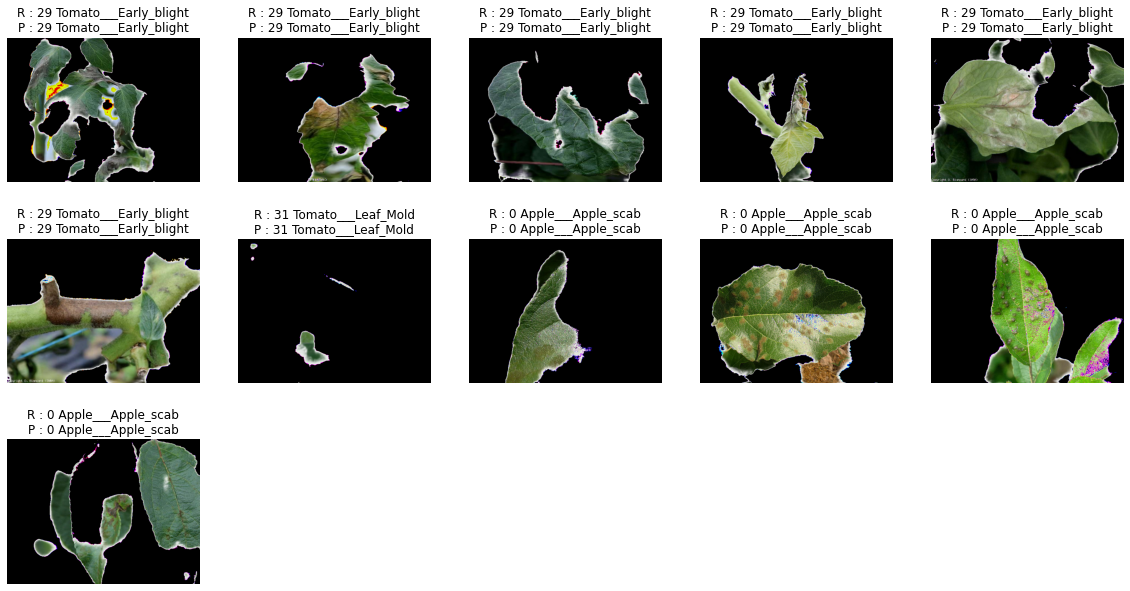

In [ ]:
plt.figure( figsize= (20,40) ) 
k = 0
for i in range(len(result)):
    num_classe_reelle = result.loc[i, 'reel']
    num_classe_pred = result.loc[i, 'pred']

    if num_classe_reelle == num_classe_pred:
        nom_classe_reelle = result.loc[i, 'nom_classe_reelle']
        nom_classe_pred = result.loc[i, 'nom_classe_pred']
        img = result.loc[i, 'image']

        k += 1
        plt.subplot(11,5,k)
        plt.imshow(img)
        plt.axis('off')
        plt.title('R : ' + str(num_classe_reelle) + ' ' + nom_classe_reelle + '\n' + 'P : ' + str(num_classe_pred) + ' ' + nom_classe_pred)

###Affichage des photos mal classées

On peut constater que la suppression du fond est parfois trop forte, il ne reste alors plus que du fond noir.

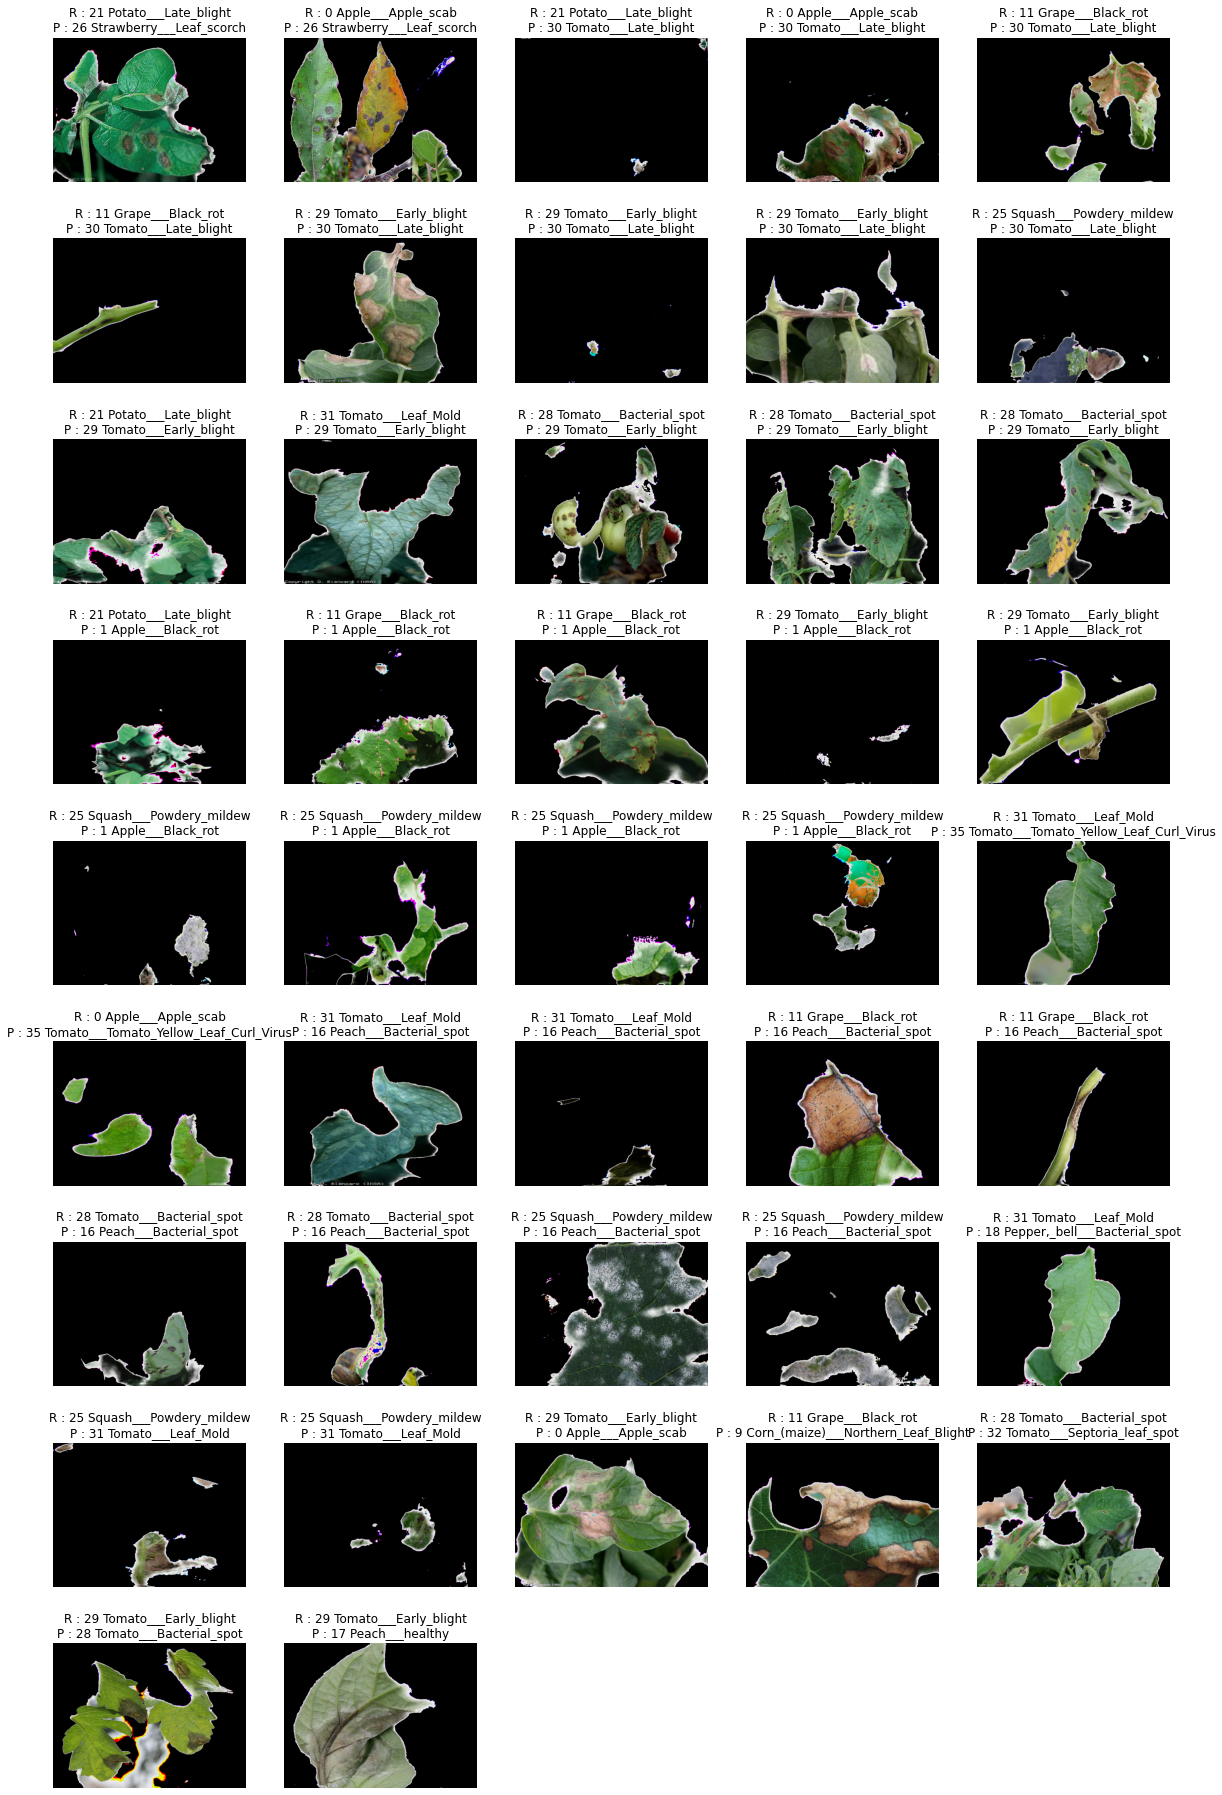

In [ ]:
plt.figure( figsize= (20,40) ) 
k = 0
for i in range(len(result)):
    num_classe_reelle = result.loc[i, 'reel']
    num_classe_pred = result.loc[i, 'pred']

    if num_classe_reelle != num_classe_pred:
        nom_classe_reelle = result.loc[i, 'nom_classe_reelle']
        nom_classe_pred = result.loc[i, 'nom_classe_pred']
        img = result.loc[i, 'image']

        k += 1
        plt.subplot(11,5,k)
        plt.imshow(img)
        plt.axis('off')
        plt.title('R : ' + str(num_classe_reelle) + ' ' + nom_classe_reelle + '\n' + 'P : ' + str(num_classe_pred) + ' ' + nom_classe_pred)



##Evaluation avec U2net

###Chargement du modèle U2net

In [ ]:
!git clone https://github.com/OPHoperHPO/image-background-remove-tool.git -b master
%cd /content/image-background-remove-tool

#!pip install -r requirements.txt
!pip install gluoncv
!pip install mxnet
!cd ./tools && echo "u2net" | python setup.py

Cloning into 'image-background-remove-tool'...
remote: Enumerating objects: 1515, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1515 (delta 3), reused 1 (delta 0), pack-reused 1499
Receiving objects: 100% (1515/1515), 102.09 MiB | 34.11 MiB/s, done.
Resolving deltas: 100% (541/541), done.
/content/image-background-remove-tool
     |████████████████████████████████| 1.3 MB 5.4 MB/s 
     |████████████████████████████████| 47.3 MB 66 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Choose which model you want to install:
u2net
basnet
u2netp
xception_model
mobile_net_model
all
Enter model name: Downloading...
From: https://github.com/OPHoperHPO/image-background-remove-tool/releases/download/3.2/u2net.pth
To: /content/image-background-remove-tool/models/u2net/u2net.pth
100% 176M/176M [00:02<00:00, 65.7MB

In [ ]:
import argparse
import os
import tqdm
import logging
from libs.strings import *
from libs.networks import model_detect
import libs.preprocessing as preprocessing
import libs.postprocessing as postprocessing

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

def supprimer_fond(input_path, 
                   model_name="u2net",
                   preprocessing_method_name="bbd-fastrcnn",
                   postprocessing_method_name="rtb-bnb"):

    if input_path is None :
        raise Exception("Bad parameters! Please specify input path and output path.")

    model = model_detect(model_name)  # Load model
    if not model:
        logger.warning("Warning! You specified an invalid model type. "
                       "For image processing, the model with the best processing quality will be used. "
                       "(u2net)")
        model_name = "u2net"  # If the model line is wrong, select the model with better quality.
        model = model_detect(model_name)  # Load model

    preprocessing_method = preprocessing.method_detect(preprocessing_method_name)
    postprocessing_method = postprocessing.method_detect(postprocessing_method_name)
    image = model.process_image(input_path, preprocessing_method, postprocessing_method)

    return np.float32(np.asarray(image))

###Prédictions

Tout comme MODNet, U2net remplace le fond par un fond blanc. Il faut le remplacer par un fond noir puisque le modèle VGG16 a été entraîné avec des feuilles sur fond noir.


Inconvénient de ce modèle par rapport au précédent : il est beaucoup plus lent. Il faut compter 15 secondes pour supprimer le fond d'une image.

In [ ]:
liste_num_classe_reelle = []
liste_num_classe_pred = []
liste_photo = []

i = 0
for fichier in glob.glob(chemin_image_test + '/**/*.jpg', recursive=True,):
    i += 1

    x = supprimer_fond(fichier)
    x = x[:,:,:3]
    x = np.where(x >= 245, 0, x) # remplacement du fond blanc par un fond noir
    x = cv2.resize(x, dsize=(largeur,hauteur), interpolation = cv2.INTER_AREA)
    img = np.uint8(x)
    x = np.expand_dims(x, axis=0) # shape= (1, 224, 224, 3)
    x = preprocess_input(x)
    num_classe_pred = model.predict(x).argmax(axis = 1)[0]
    liste_num_classe_pred.append(num_classe_pred)

    chemin = os.path.split(fichier)[0]
    nom_classe_reelle = os.path.split(chemin)[1]
    num_classe_reelle = CLASSES[nom_classe_reelle]
    liste_num_classe_reelle.append(num_classe_reelle)

    liste_photo.append(img)

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


121888KB [00:05, 24292.91KB/s]                            


In [ ]:
# Chargement d'informations complémentaires sur les classes
result = pd.DataFrame()
result['reel'] = liste_num_classe_reelle
result['pred'] = liste_num_classe_pred
result['image'] = liste_photo

result = pd.merge(result, df, left_on=['reel'], right_on=['classe'])[['reel','pred','image','dossier','plante_francais','nom_classe_fusionnee']]
result = result.rename({'dossier' : 'nom_classe_reelle',
                        'plante_francais' : 'plante_reelle',
                        'nom_classe_fusionnee' : 'nom_classe_fusionnee_reelle'}, axis = 1)

result = pd.merge(result, df, left_on=['pred'], right_on=['classe'])[['reel','pred','image','nom_classe_reelle', 'plante_reelle', 'nom_classe_fusionnee_reelle', 'dossier','plante_francais','nom_classe_fusionnee']]
result = result.rename({'dossier' : 'nom_classe_pred',
                        'plante_francais' : 'plante_pred',
                        'nom_classe_fusionnee' : 'nom_classe_fusionnee_pred'}, axis = 1)



###Evaluation par classe

Les résultats ne sont pas meilleurs qu'avec MODnet : accuracy de 0.06

In [ ]:
print(classification_report(result['nom_classe_reelle'], result['nom_classe_pred']))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.00      0.00      0.00         7
                            Apple___Black_rot       0.00      0.00      0.00         0
                     Apple___Cedar_apple_rust       0.00      0.00      0.00         0
          Corn_(maize)___Northern_Leaf_Blight       0.00      0.00      0.00         0
                            Grape___Black_rot       0.00      0.00      0.00         7
                       Peach___Bacterial_spot       0.00      0.00      0.00         0
                Pepper,_bell___Bacterial_spot       0.00      0.00      0.00         0
                         Potato___Late_blight       0.00      0.00      0.00         4
                      Squash___Powdery_mildew       0.00      0.00      0.00         9
                      Tomato___Bacterial_spot       0.00      0.00      0.00         6
                        Tomato___Early_bli

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

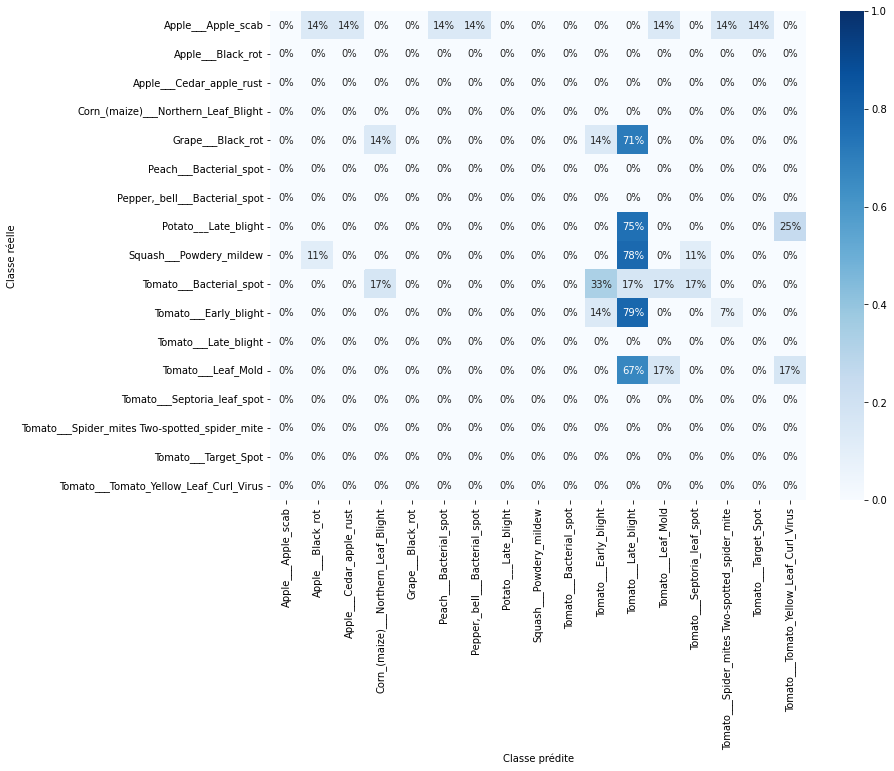

In [ ]:
matrice_confusion(result['nom_classe_reelle'], result['nom_classe_pred'], 'Classe réelle', 'Classe prédite', cmap = 'Blues', figsize=(12,9))

###Evaluation par plante

In [ ]:
print(classification_report(result['plante_reelle'], result['plante_pred']))

                precision    recall  f1-score   support

        Courge       0.00      0.00      0.00         9
          Maïs       0.00      0.00      0.00         0
        Poivre       0.00      0.00      0.00         0
         Pomme       0.67      0.29      0.40         7
Pomme de terre       0.00      0.00      0.00         4
         Pêche       0.00      0.00      0.00         0
        Tomate       0.54      0.96      0.69        26
         Vigne       0.00      0.00      0.00         7

      accuracy                           0.51        53
     macro avg       0.15      0.16      0.14        53
  weighted avg       0.35      0.51      0.39        53



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

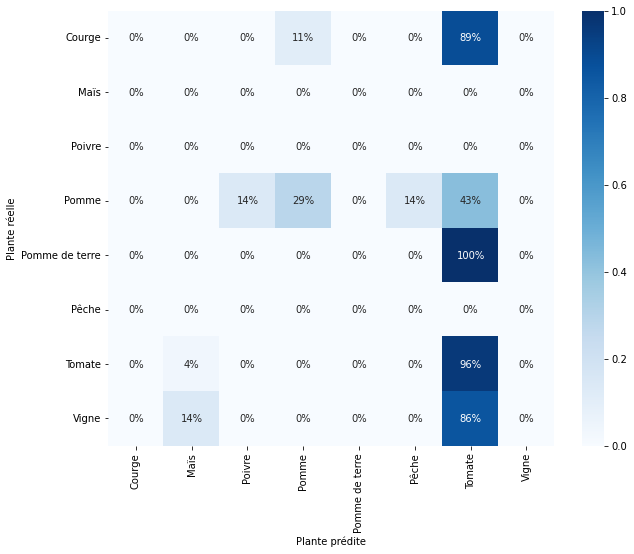

In [ ]:
matrice_confusion(result['plante_reelle'],result['plante_pred'], 'Plante réelle', 'Plante prédite', cmap='Blues')

###Affichage des photos bien classées

Les photos bien classées sont très bien détourées.

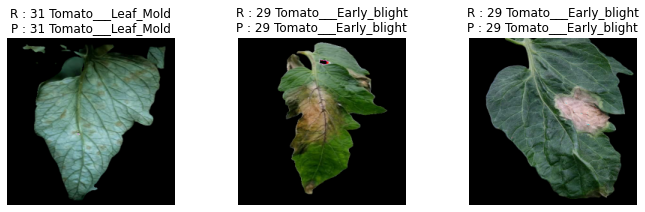

In [ ]:
plt.figure( figsize= (20,40) ) 
k = 0
for i in range(len(result)):
    num_classe_reelle = result.loc[i, 'reel']
    num_classe_pred = result.loc[i, 'pred']

    if num_classe_reelle == num_classe_pred:
        nom_classe_reelle = result.loc[i, 'nom_classe_reelle']
        nom_classe_pred = result.loc[i, 'nom_classe_pred']
        img = result.loc[i, 'image']

        k += 1
        plt.subplot(11,5,k)
        plt.imshow(img)
        plt.axis('off')
        plt.title('R : ' + str(num_classe_reelle) + ' ' + nom_classe_reelle + '\n' + 'P : ' + str(num_classe_pred) + ' ' + nom_classe_pred)

###Affichage des photos mal classées

Il y a encore plus de photos toutes noires qu'avec le modèle MODnet

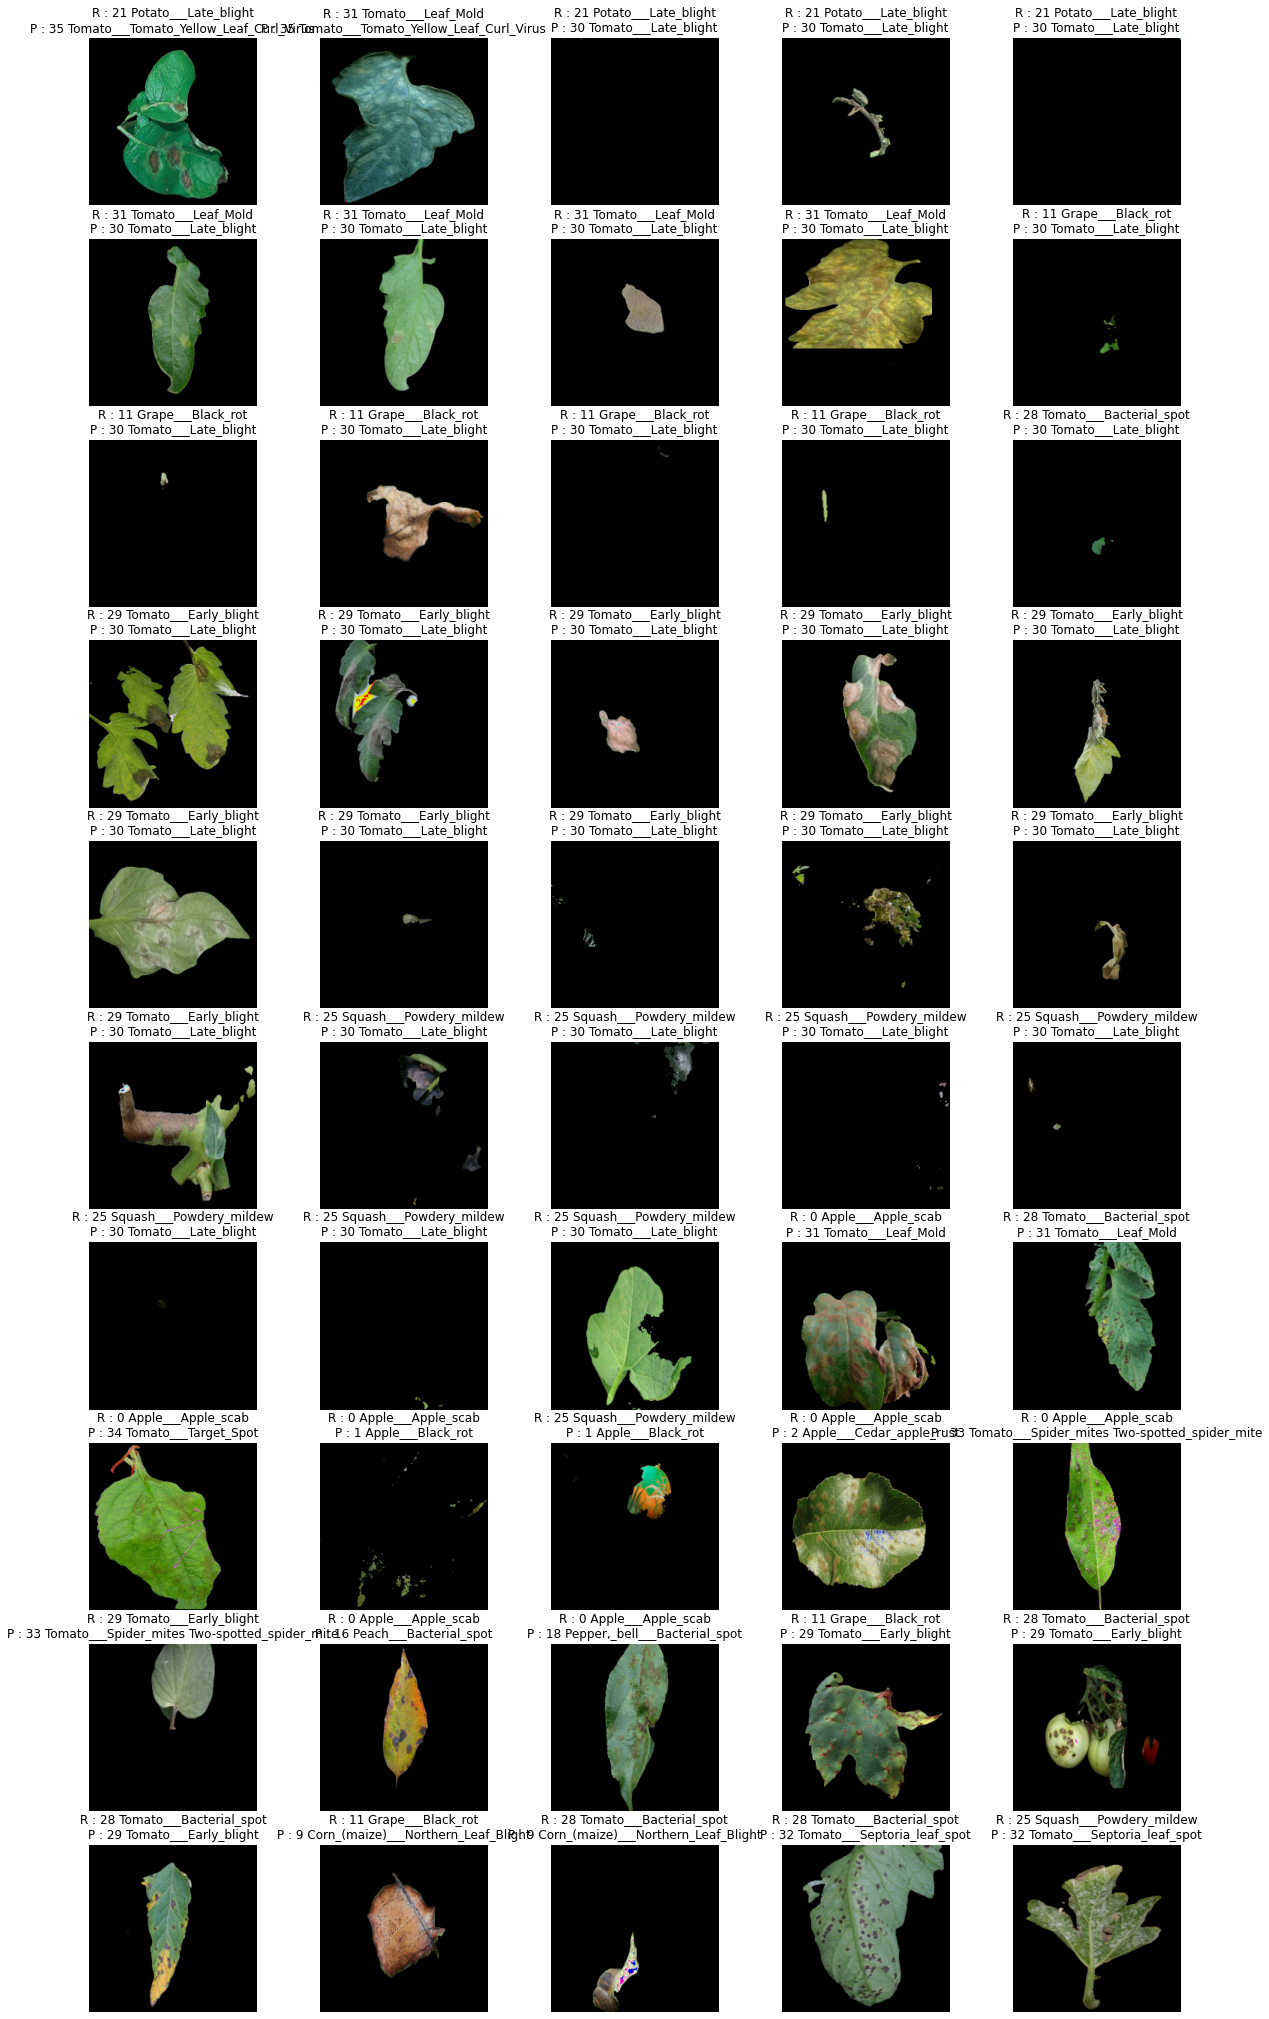

In [ ]:
plt.figure( figsize= (20,40) ) 
k = 0
for i in range(len(result)):
    num_classe_reelle = result.loc[i, 'reel']
    num_classe_pred = result.loc[i, 'pred']

    if num_classe_reelle != num_classe_pred:
        nom_classe_reelle = result.loc[i, 'nom_classe_reelle']
        nom_classe_pred = result.loc[i, 'nom_classe_pred']
        img = result.loc[i, 'image']

        k += 1
        plt.subplot(11,5,k)
        plt.imshow(img)
        plt.axis('off')
        plt.title('R : ' + str(num_classe_reelle) + ' ' + nom_classe_reelle + '\n' + 'P : ' + str(num_classe_pred) + ' ' + nom_classe_pred)

##Conclusion

Que ce soit avec MODnet ou U2net, les scores sont mauvais, encore plus qu'à l'itération précédente. La suppression du fond est parfois trop forte : ces deux modèles ont été entraînés sur des portraits et non sur des plantes.

#Conclusion

Dans le cadre de ce sprint (modélisation N°3), nous avons mis en place:
 - Partiellement la méthode 3 qui consiste à segmenter les images à l'aide d'un modèle UNET pour les utiliser dans le modèle de la méthode 2 (VGG16)

- La Méthode 4: Utilisation des modèles préentrainés suivants:
  - MODNet
  - U2NET

- Une piste d'amélioration : l'utilisation d'un modèle à double sortie. Voir fichier Modele_bisortie_iteration3_modele_base_et_plante_dependantes_261221_#0

Malheureusement la méthode 3 a été plus difficile que prévue à implémenter à cause de l'utilisation d'ImageDataGenerator sur le modèle UNET à cause de la quantité de données et des problèmes de RAM. Les méthodes de segmentation traditionnelles (sans Deep Learning) ne fonctionnent pas sur nos données.

La méthode 4 présente une accuracy inférieure à la méthode 2: 0.06 vs 0.17.
Le détourage des images est trop fort. Le modèle est préentrainé sur des portraits ce qui explique ces résultats.

L'utilisation d'un modèle de deep learning avec deux sorties différentes pour la plante et la maladie présente des résultats légèrement meilleurs que le modèle de la méthode 2. Les résultats sur les images du monde réel restent médiocres.
Le rééquilibrage des classes et l'augmentation des données par des transformations géométriques ne permettent pas non plus d'améliorer franchement l'accuracy des images du monde réel. 

Les pistes d'améliorations non traitées de l'itération précédente sont toujours valables:
 - Tester d'autres modèles de Deep Learning pour la classification.
 - Créer un modèle de détection de plante puis un modèle de détection de maladie.
 - Fusionner les classes Tomato___Early_blight / Tomato___Late_blight, 
Potato___Early_blight / Potato___Late_blight

Suite à cette itération les pistes d'améliorations privilégiées sont:
 - Finaliser la méthode de segmentation entrainées sur nos données.
 - Tenter de trouver des modèles préentrainés sur des plantes.

L'amélioration de la segmentation est privilégiée car elle devrait permetre de mieux classer les photos des images réelles qui correspondent à l'objectif de ce projet.